In [1]:
!date

Tue May  1 09:46:53 CDT 2018


#### Python [conda env: wrs-plots]

In [2]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2

In [3]:
import datetime
x = datetime.datetime.now() - datetime.timedelta(days=10)
start, end = x.replace(day=1).strftime('%Y-%m-%d'), x.replace(day=30).strftime('%Y-%m-%d')
start, end

('2018-04-01', '2018-04-30')

In [4]:
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))

In [5]:
sql = '''
select  count(*) n_scenes, 
        case when split_part(s.name, '_', 2) = '' 
            then right(left(s.name,6),3)
            else left(split_part(s.name, '_', 3), 3) end as path,
        
        case when split_part(s.name, '_', 2) = '' 
            then right(left(s.name,9),3)
            else right(split_part(s.name, '_', 3), 3) end as row

from ordering_scene s
left join ordering_order o on o.id=s.order_id

where
    o.order_date::date >= '{0}'
    and o.order_date::date <= '{1}'
--    and s.download_size > 0
    and s.sensor_type = 'landsat'
    
group by path, row

;
'''.format(start, end)

dat = sqlio.read_sql_query(sql, conn)
print(dat['n_scenes'].max(), dat['n_scenes'].sum())
dat.head()

(3784, 317717)


,n_scenes,path,row
0,3,096,081
1,6,162,027
2,141,040,023
3,9,075,066
4,5,110,022


In [6]:
conn = None

---

In [7]:
import shapely
import shapely.ops

import geopandas as gp

def load_wrs(filename='wrs2_asc_desc/wrs2_asc_desc.shp'):
    wrs = gp.GeoDataFrame.from_file(filename)
    # PATH, ROW, geometry
    return wrs
FEATURES = load_wrs()

In [8]:
%pylab inline
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
import numpy as np
#from descartes import PolygonPatch
from matplotlib.patches import Polygon
from IPython.display import Image

def get_poly_wrs(path, row, features=FEATURES, facecolor='w'):
    prid = '{}_{}'.format(path, row)
    ix = (features['PATH'] == path) & (features['ROW'] == row)
    geom = features[ix]
    #geom = [f for f in features if prid == f.name]
    if (len(geom) != 1):
        print(prid)
        print(geom)
        raise AssertionError()
    poly = geom.geometry.values[0]
    if poly.geom_type == 'Polygon':
        lons, lats = poly.exterior.coords.xy
    elif poly.geom_type == 'MultiPolygon':
        lons = []; lats = []
        for subpoly in poly:
            ln, la = subpoly.exterior.coords.xy
            lons += ln; lats+=la
    return lons, lats 

def plot_poly(lons, lats, mm, **kwargs):
    # facecolor='red', edgecolor='red', alpha=0.1
    x, y = mm( lons, lats )
    xy = zip(x,y)
    patch = Polygon( xy, **kwargs )
    return patch

FIGSIZE=(10,6)
def make_basemap(path_rows_alpha):
    water = 'white'
    earth = 'grey'
    #font = {'size'   : 20}
    #mpl.rc('font', **font)
    RED = '#f03b20'
    fig, ax = plt.subplots(figsize=FIGSIZE)
    mm = Basemap(llcrnrlon=-180,llcrnrlat=-60,urcrnrlon=180,urcrnrlat=90, projection='mill')
    #mm = Basemap(projection='mill',lon_0=0)
    mm.drawmapboundary()
    coast = mm.drawcoastlines()
    continents = mm.fillcontinents(color=earth, lake_color=water)
    bound= mm.drawmapboundary(fill_color=water)
    countries = mm.drawcountries()
    merid = mm.drawmeridians(np.arange(-180, 180, 60), labels=[False, False, False, True])
    parall = mm.drawparallels(np.arange(-80, 80, 20), labels=[True, False, False, False])

    ax = plt.gca()
    
    for path, row, alpha in path_rows_alpha:
        lons, lats = get_poly_wrs(path, row)
        delta_lons = abs(max(lons) - min(lons))
        if delta_lons > 180:
            #print('PATH {} ROW {} | MINLON {} MAXLON {}'.format(path, row, min(lons), max(lons)))
            def p_dateline(x):
                if x > 0:
                    return x-360
                return x
            lons = map(p_dateline, lons)
        patch = plot_poly(lons, lats, mm, facecolor='red', edgecolor='red', alpha=alpha )
        ax.add_patch(patch)

Populating the interactive namespace from numpy and matplotlib


# Show geographic regions of products

In [9]:
MINALPHA=0.035
MAXALPHA=1.0
MINVALUES=dat['n_scenes'].min()
MAXVALUES=dat['n_scenes'].max()
def get_alpha(x, b, a, mmin, mmax):
    # b = max desired
    # a = min desired
    return  a + (((b-a)*(x-mmin))/(mmax-mmin))
    
dat['path'] = dat['path'].astype(int)
dat['row'] = dat['row'].astype(int)
dat['alpha'] = dat['n_scenes'].apply(lambda v: get_alpha(v, MAXALPHA, MINALPHA, MINVALUES, MAXVALUES))

dat = dat.sort_values(by='alpha')
path_rows_alpha = dat[['path', 'row', 'alpha']].values
dat.tail()

,n_scenes,path,row,alpha
5079,1954,28,33,0.533188
6698,1955,30,32,0.533443
2981,1965,127,36,0.535994
3311,3773,29,34,0.997194
4694,3784,29,33,1.000000


In [10]:
def fake_cb():
    mmin, mmax = (MINVALUES, MAXVALUES)
    step = 100
    mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['white','red'])
    # Using contourf to provide my colorbar info, then clearing the figure
    Z = [[0,0],[0,0]]
    plt.subplots(figsize=FIGSIZE, facecolor='w')
    levels = range(mmin,mmax+step,step)
    CS3 = plt.contourf(Z, levels, cmap=mymap)
    plt.clf()
    return CS3
cb = fake_cb()

/tmp/paths_rows_ordered_ALL.png


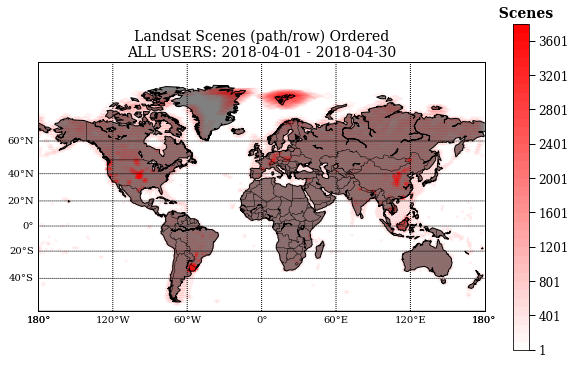

In [11]:
make_basemap(path_rows_alpha)
plt.title('Landsat Scenes (path/row) Ordered\nALL USERS: {} - {}'.format(start, end), fontsize=14)
cbar = plt.colorbar(cb); cbar.ax.set_title('  Scenes',weight='bold', fontsize=14); cbar.ax.tick_params(labelsize=12) 
pltfname = '/tmp/paths_rows_ordered_ALL.png'
print(pltfname)
plt.savefig(pltfname, bbox_inches='tight')